In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as pl
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.metrics import accuracy_score


In [2]:
df = pd.read_csv('sap_storing_data_hu_project.csv')

C:\Users\hasso\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,11,19,21,24,25,27,32,33,36,37,38,39,40,46,47,48,49,51,53,55,56,60,73,75,78,80,82,83,86,87,91,95,99,102,103,104,107,108,109,110,111,112,113,116,118,119,120,121,122,123,124,129) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
def column_outlier(strength, dataframe, columns):
    temp_dataframe = dataframe.copy()
    try:
        if strength == 's':
            strength=3
        elif strength == 'a':
            strength=1.5
    except:
        print("Invalid strength")
    for column in columns:
        Q1 = temp_dataframe[column].quantile(0.25)
        Q3 = temp_dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        temp_dataframe = temp_dataframe[~((temp_dataframe[column] < (Q1 - strength * IQR)) |(temp_dataframe[column] > (Q3 + strength* IQR)))]
    return temp_dataframe

In [4]:
def get_accuracy(r,zip_list):
    return len([ _ for x in zip_list if x[0]+r >= x[1] >= x[0]-r])/len(zip_list)

<h2>Data Cleaning </h2>

In [5]:
# ik zorg er hier voor dat de 'stm_progfh_in_duur' kolom naar floats gecast wordt
df.stm_progfh_in_duur = df.stm_progfh_in_duur.apply(lambda x: float(str(x).replace('-','').replace('*','').strip()))

# delete stm_fh_duur outliers
#df = column_outlier('a', df.copy(), ['stm_fh_duur'])


# voeg dummy kolommen voor seizoenen toe
df.stm_sap_melddatum = pd.to_datetime(df.stm_sap_melddatum)

df['date_offset'] = (df.stm_sap_melddatum.dt.month*100 + df.stm_sap_melddatum.dt.day - 320)%1300

df['seizoen_melding'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                      labels=['spring', 'summer', 'autumn', 'winter'])

df.drop(['date_offset'], axis=1)
df = df.join(pd.get_dummies(df.seizoen_melding))

# join de oorzaakcodes
o_df = pd.read_csv('Oorzaakcodes.csv', sep = ';')
o_df = o_df.rename(columns={'Code': 'stm_oorz_code'})
df = df.merge(o_df, on = 'stm_oorz_code', how = 'outer')

# join de goetrajectcodes
geo_df = pd.read_csv('geocodes.csv',sep = ';') 
geo_df = geo_df.rename(columns={'Code': 'stm_geo_mld'})
df = df.merge(geo_df, on = 'stm_geo_mld', how = 'outer') 

# join de Contractgebiedcodes
cg = pd.read_excel('Contractgebiedcodes.xlsx') #Contract gebied storing
cg = cg.rename(columns={'Code': 'stm_contractgeb_gst'})
df = df.merge(cg, on = 'stm_contractgeb_gst', how = 'outer')

# maak target var bins zodat we classification kunnen gebruiken
error_margin  = 10
bins = [x for x in range(0,900,error_margin)]
labels = [x for x in range(1,len(bins))]
df['duration_bin'] = pd.cut(df['stm_fh_duur'], bins = bins, labels=labels)


# we willen alleen durations die niet gelijk zijn aan 0 en kleiner zijn dan 8 uur
df = df[(df.stm_fh_duur != 0) & (df.duration_bin <= 48)]


# kolom voor meltijd h
df['meldtijd_h'] = df.stm_sap_meldtijd.str.split(':').str[0]


In [6]:
pd.set_option('display.max_rows', None)

In [7]:
pd.set_option('display.max_columns', None)

<AxesSubplot:xlabel='stm_fh_duur', ylabel='Density'>

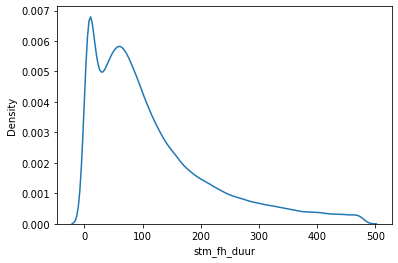

In [8]:
sns.kdeplot(df.stm_fh_duur)

In [9]:
mean_durgeo_df = column_outlier('a', df.copy(), ['stm_fh_duur'])[['stm_fh_duur', 'Traject']].groupby('Traject', as_index = False).mean()
mean_durgeo_df

,Traject,stm_fh_duur
0,Alkmaar,64.536585
1,Alkmaar - Uitgeest,103.764706
2,Almelo,78.240000
3,Almelo - Hengelo,39.666667
4,Alphen a/d Rijn,66.400000
5,Alphen a/d Rijn - Leiden Centraal,91.777778
6,Amersfoort,71.034014
7,Amersfoort Aansl.,91.000000
8,Amersfoort Aansl. - Barneveld Noord,98.555556
9,Amersfoort Aansl. - Hattemerbroek,120.861111


<AxesSubplot:xlabel='stm_fh_duur', ylabel='Traject'>

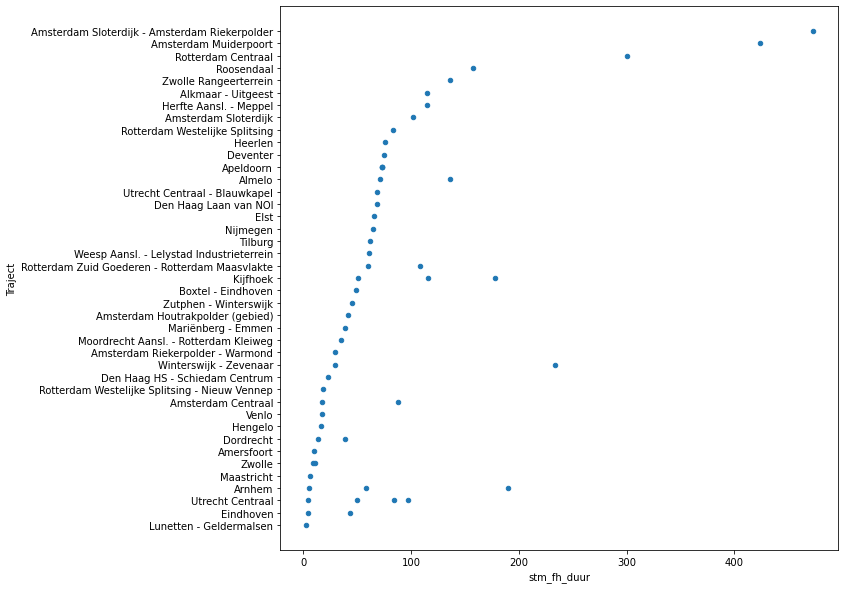

In [10]:
x = 'stm_fh_duur'
y = 'Traject'

tplot = df.sample(4000)[[x, y]]
tplot.sort_values(['stm_fh_duur'], ascending=True, inplace=True)
tplot.dropna(inplace=True)

tplot.plot(x=x, y=y, kind='scatter',figsize=(10,10))

C:\Users\hasso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-11-89b5bd9a5ab2>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


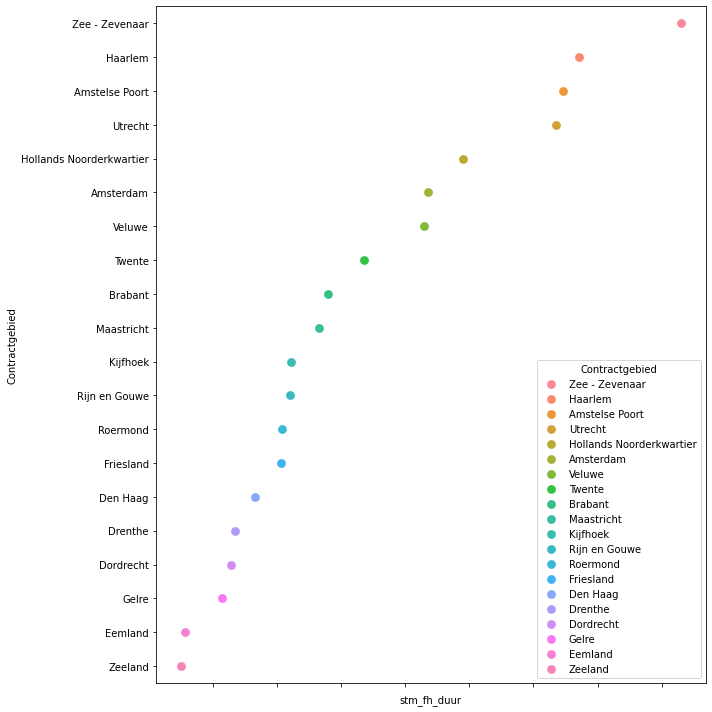

In [11]:
mean_cg_df = column_outlier('a', df.copy(), ['stm_fh_duur'])[['stm_fh_duur', 'Contractgebied']].groupby('Contractgebied', as_index = False).mean()
plt.figure(figsize=(10,10))
new_data= mean_cg_df.sort_values(by ='stm_fh_duur' , ascending=False)
new_data_sort=new_data.head(20)
ax=sns.pointplot(new_data_sort['stm_fh_duur'], new_data_sort['Contractgebied'], hue=new_data_sort['Contractgebied'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()


<h2> MODEL COMPARISON </h2>

In [12]:
# svm, random forests en gaussion process classifier duren veels te lang op deze dataset

dt_df = df.copy()[['duration_bin', 'stm_equipm_nr_mld','stm_reactie_duur', 'stm_prioriteit', 'stm_km_tot_mld', 'stm_km_van_mld','spring', 'summer','autumn','winter']].dropna()


dt_df = dt_df.join(pd.get_dummies(df.stm_contractgeb_gst)).dropna()
dt_df = dt_df.join(pd.get_dummies(df.meldtijd_h)).dropna()


X = dt_df.drop(columns = ['duration_bin'])
y = dt_df['duration_bin']



X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X, y, test_size=0.2)

#c = GridSearchCV(DecisionTreeClassifier(), {'max_depth' : [i for i in range(1,200)]})
#clf = c.fit(X_train_dt, y_train_dt)

clf = DecisionTreeClassifier(max_depth = 84, random_state = 0).fit(X_train_dt, y_train_dt)
y_pred_dt = clf.predict(X_test_dt)

accuracy_score(y_test_dt,y_pred_dt)

0.5710021504456023

In [13]:
dt_df1 = df.copy()[['duration_bin', 'stm_equipm_nr_mld','stm_reactie_duur', 'stm_prioriteit', 'stm_km_tot_mld', 'stm_km_van_mld','spring', 'summer','autumn','winter']].dropna()

In [14]:
corrMatrix = dt_df1.corr()
corrMatrix

,stm_equipm_nr_mld,stm_reactie_duur,stm_prioriteit,stm_km_tot_mld,stm_km_van_mld,spring,summer,autumn,winter
stm_equipm_nr_mld,1.000000,0.104937,0.154172,0.092428,0.002087,0.010316,-0.006617,-0.004491,-0.000447
stm_reactie_duur,0.104937,1.000000,0.028007,0.170789,-0.000183,-0.005468,-0.016071,-0.018600,0.039239
stm_prioriteit,0.154172,0.028007,1.000000,-0.002372,0.002723,-0.001338,-0.008257,0.008296,0.001161
stm_km_tot_mld,0.092428,0.170789,-0.002372,1.000000,0.120784,-0.005078,-0.002439,0.000722,0.006426
stm_km_van_mld,0.002087,-0.000183,0.002723,0.120784,1.000000,0.003572,-0.000237,-0.002419,-0.000971
spring,0.010316,-0.005468,-0.001338,-0.005078,0.003572,1.000000,-0.345497,-0.326448,-0.342156
summer,-0.006617,-0.016071,-0.008257,-0.002439,-0.000237,-0.345497,1.000000,-0.321783,-0.337268
autumn,-0.004491,-0.018600,0.008296,0.000722,-0.002419,-0.326448,-0.321783,1.000000,-0.318672
winter,-0.000447,0.039239,0.001161,0.006426,-0.000971,-0.342156,-0.337268,-0.318672,1.000000


<AxesSubplot:>

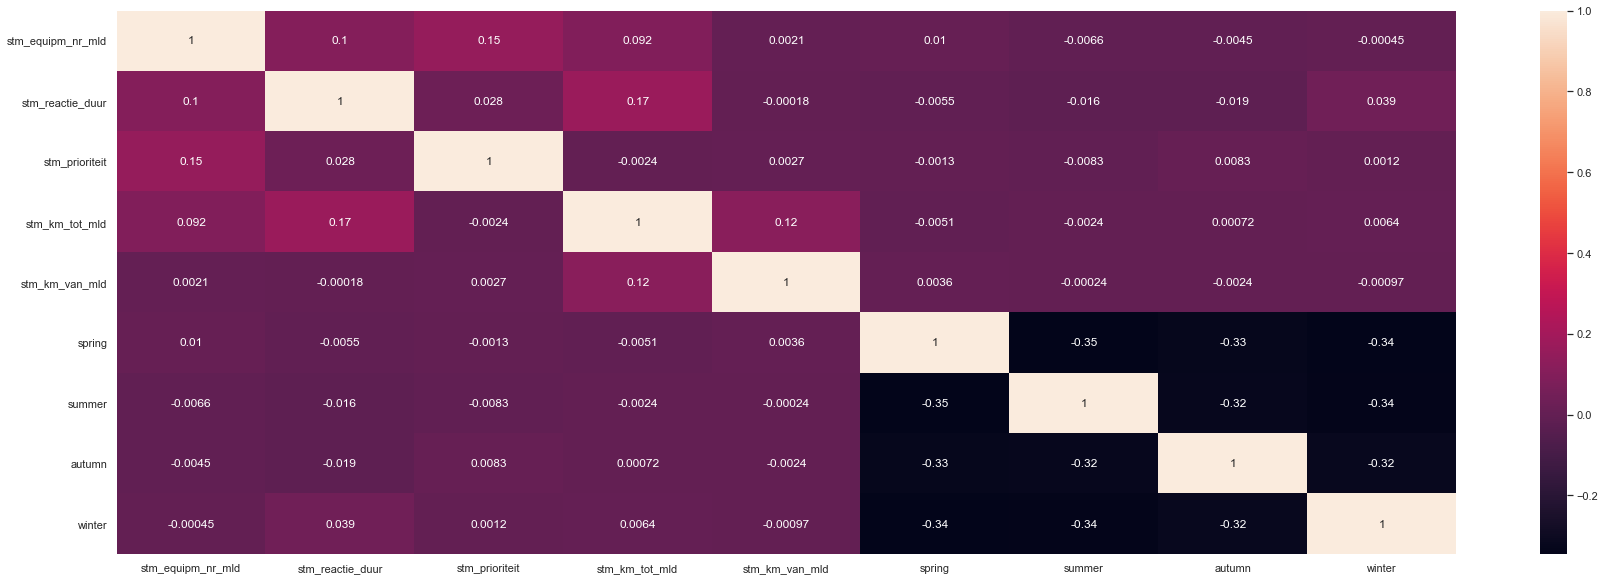

In [15]:
sns.set(rc = {'figure.figsize':(30,10)})
sns.heatmap(corrMatrix, annot=True)

<AxesSubplot:>

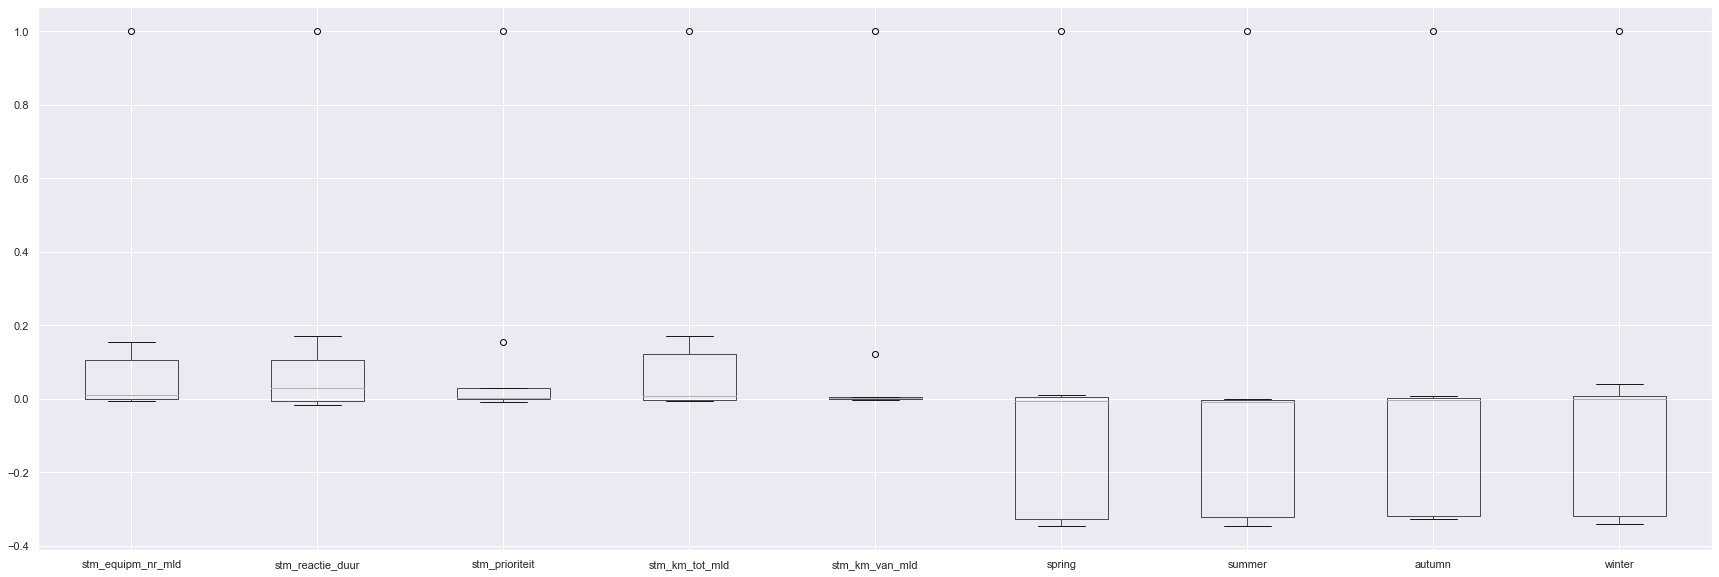

In [16]:
corrMatrix.boxplot(figsize=(30,10))

In [17]:
# svm, random forests en gaussion process classifier duren veels te lang op deze dataset

kn_df = df[['duration_bin','stm_equipm_nr_mld','stm_reactie_duur', 'stm_prioriteit', 'stm_km_tot_mld', 'stm_rapportage_jaar','spring', 'summer','autumn','winter']].dropna()

X = kn_df.drop(columns = ['duration_bin'])
y = kn_df.duration_bin

X_train_kn, X_test_kn, y_train_kn, y_test_kn = train_test_split(X, y, test_size=0.2)

clf2 = KNeighborsClassifier(n_neighbors = 1).fit(X_train_kn, y_train_kn)

y_pred_kn = clf2.predict(X_test_kn)
accuracy_score(y_test_kn,y_pred_kn)

0.5553606008409205

In [18]:
bins = [x for x in range(0,900,error_margin)]
labels = [x for x in range(1,len(bins))]
prog_df = df.copy()[['stm_progfh_in_duur','duration_bin']]
prog_df = column_outlier('a', prog_df.copy(), ['stm_progfh_in_duur'])
prog_df['prog_duration_bin'] = pd.cut(prog_df['stm_progfh_in_duur'], bins = bins, labels=labels)
prog_df = prog_df.dropna()
prog_df = prog_df[['duration_bin', 'prog_duration_bin']]

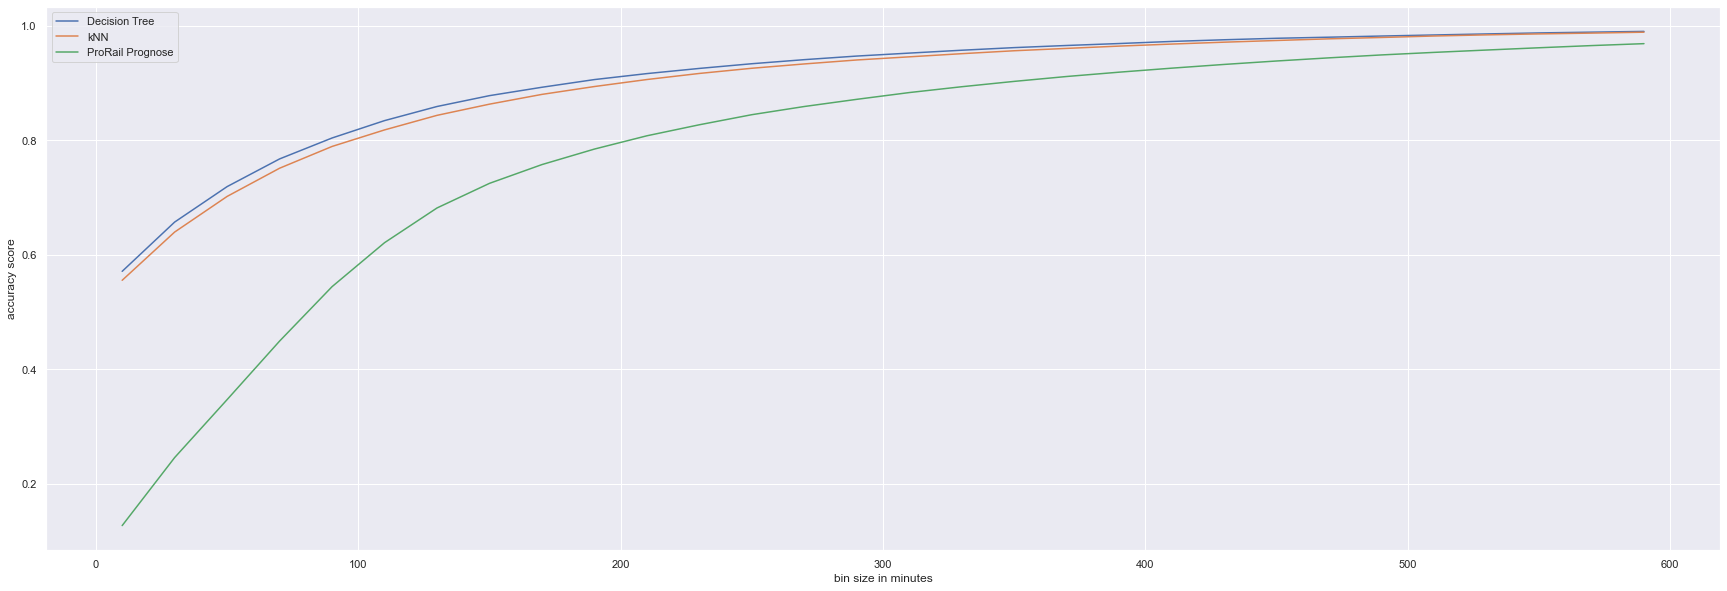

In [19]:
x_ax = [error_margin +(20*x) for x in range(0,30)]

y1_ax = [get_accuracy(x, list(zip(list(y_test_dt), y_pred_dt))) for x in range(0,30)]
y2_ax = [get_accuracy(x, list(zip(list(y_test_kn), y_pred_kn))) for x in range(0,30)]

df_co = df.copy()[['Oorzaak', 'duration_bin']].dropna()
X = df_co['Oorzaak']
y = df_co['duration_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


y3_ax = [get_accuracy(x, list(zip(list(prog_df.duration_bin), list(prog_df.prog_duration_bin)))) for x in range(0,30)]


plt.plot(x_ax,y1_ax, label = 'Decision Tree')
plt.plot(x_ax,y2_ax, label = 'kNN')
plt.plot(x_ax,y3_ax, label = 'ProRail Prognose')



plt.xlabel('bin size in minutes')
plt.ylabel('accuracy score')

plt.legend()
plt.show()

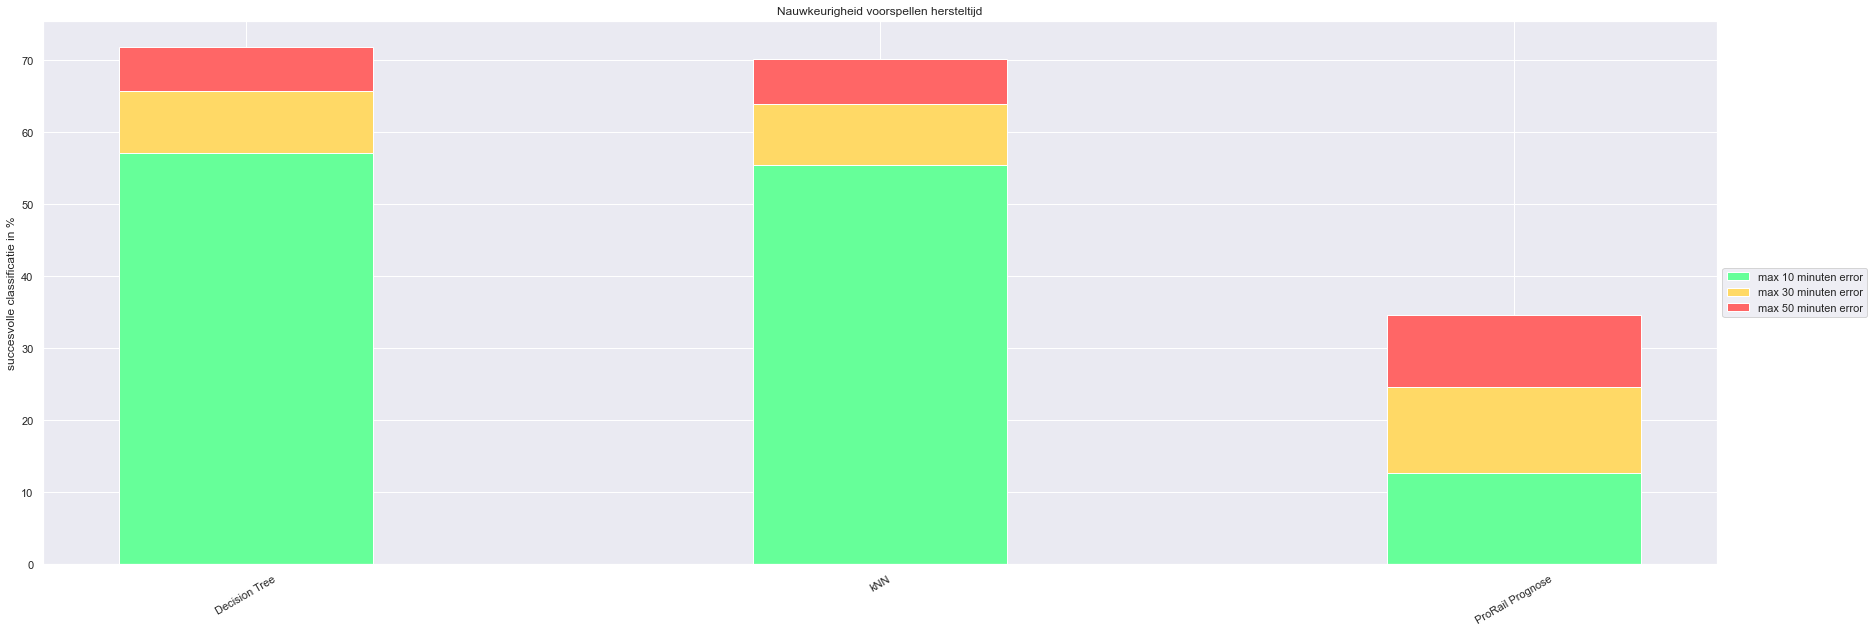

In [20]:
labels = ['Decision Tree', 'kNN', 'ProRail Prognose']

min_10 = [100 * eval(f"y{i}_ax[0]") for i in range(1,len(labels)+1)]
min_30 = [100 * (eval(f"y{i}_ax[1]") - eval(f"y{i}_ax[0]")) for i in range(1,len(labels)+1)]
min_50 = [100 * (eval(f"y{i}_ax[2]") - eval(f"y{i}_ax[1]")) for i in range(1,len(labels)+1)]

width = 0.4  

fig, ax = plt.subplots()

ax.bar(labels, min_10, width, label='max 10 minuten error', color = '#66ff99')
ax.bar(labels, min_30, width ,bottom=min_10,label='max 30 minuten error', color = '#ffd966')
ax.bar(labels, min_50, width ,bottom=(np.array(min_30) + np.array(min_10)),label='max 50 minuten error', color = '#ff6666')


ax.set_ylabel('succesvolle classificatie in %')
ax.set_title('Nauwkeurigheid voorspellen hersteltijd')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=30)

plt.show()

In [21]:
list(X_train_dt.columns)

['stm_equipm_nr_mld',
 'stm_reactie_duur',
 'stm_prioriteit',
 'stm_km_tot_mld',
 'stm_km_van_mld',
 'spring',
 'summer',
 'autumn',
 'winter',
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 70.0,
 71.0,
 81.0,
 82.0,
 83.0,
 99.0,
 '',
 '00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23']

In [22]:
list(X_train_kn.columns)

['stm_equipm_nr_mld',
 'stm_reactie_duur',
 'stm_prioriteit',
 'stm_km_tot_mld',
 'stm_rapportage_jaar',
 'spring',
 'summer',
 'autumn',
 'winter']

In [23]:
# base chance for a right classification by guessing the most common bin
max(df.duration_bin.dropna().value_counts())/len(df.duration_bin.dropna())

0.08928084097409525

In [24]:
# decision tree
[y1_ax[0],y1_ax[1],y1_ax[2]]

[0.5710021504456023, 0.6570520707400315, 0.7189977425670543]

In [25]:
# kNN
[y2_ax[0],y2_ax[1],y2_ax[2]]

[0.5553606008409205, 0.6396238325006152, 0.7018690688891505]

In [26]:
# prorail prognose
[y3_ax[0],y3_ax[1],y3_ax[2]]

[0.12693245519217716, 0.24573540132223926, 0.34697468640808427]